# Predict hiking times based on statistics from GPX files

We attempt to predict the walking times (or more precisely the moving times) for hikes based on statistics extracted from GPX files. Using personal GPX records as input, the outputs are personalized as well.

We use the `tf.keras` API, see [this guide](https://www.tensorflow.org/guide/keras) for details.

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import pathlib

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
import numpy as np
import h5py

import gpxStats
import utils

print(tf.__version__)

2.2.0


### Load data
Load the dataset that was prepared by running `prepareData.py`.

In [2]:
# run prepareData.py '~/GPX-Tracks' 'Wandern'

In [3]:
train_dataset_file = 'hiking_data_training.hdf5'
test_dataset_file = 'hiking_data_test.hdf5'

Convert data to a pandas dataframe:

In [4]:
def read_hdf5_to_dict(file_name):
    hdf5_data = h5py.File(file_name, 'r')
    hdf5_data_dict = {}
    for name in gpxStats.GpxSegmentStats.getHeader():
        if name == 'Path':
            hdf5_data_dict[name] = [gpxStats.PathFeature(data) for data in hdf5_data[name]]
        else:
            hdf5_data_dict[name] = hdf5_data[name][...]

    hdf5_data.close()
    return hdf5_data_dict

train_hdf5_data_dict = read_hdf5_to_dict(train_dataset_file)
test_hdf5_data_dict = read_hdf5_to_dict(test_dataset_file)

path_features_shape = train_hdf5_data_dict['Path'][0].shape
    
train_dataset = pd.DataFrame.from_dict(train_hdf5_data_dict)
test_dataset = pd.DataFrame.from_dict(test_hdf5_data_dict)

train_dataset.tail()

,Length2d,Length3d,Duration,MovingTime,StoppedTime,TotalUphill,TotalDownhill,Path
5418,52.264453,53.381755,58.0,58.0,0.0,0.000000,10.733358,<gpxStats.PathFeature object at 0x7faa609fc978>
5419,91.418732,93.330839,108.0,108.0,0.0,0.000000,17.266683,<gpxStats.PathFeature object at 0x7faa609fc9b0>
5420,53.690754,54.113753,52.0,52.0,0.0,5.533285,0.000000,<gpxStats.PathFeature object at 0x7faa609fc9e8>
5421,52.206475,52.522497,41.0,41.0,0.0,5.733317,0.000000,<gpxStats.PathFeature object at 0x7faa609fca20>
5422,70.170335,70.517933,68.0,68.0,0.0,0.000000,6.733358,<gpxStats.PathFeature object at 0x7faa609fca58>


### Split features from labels

Separate the target value, or "label", from the features. This label is the value that we will train the model to predict.

In [5]:
label_columns = ['MovingTime', 'StoppedTime', 'Duration']
train_labels_data = []
test_labels_data = []

for col_name in label_columns:
    train_labels_data.append(train_dataset.pop(col_name))
    test_labels_data.append(test_dataset.pop(col_name))

train_labels = pd.concat(train_labels_data, axis=1)
train_labels.sort_index(inplace=True)
test_labels = pd.concat(test_labels_data, axis=1)
test_labels.sort_index(inplace=True)

def convert_paths_to_array(path_features):
    return np.array([path_data.data for path_data in path_features])

train_paths = train_dataset.pop('Path')
train_paths_as_array = convert_paths_to_array(train_paths)

test_paths = test_dataset.pop('Path')
test_paths_as_array = convert_paths_to_array(test_paths)

## The model

### Build the model

Let's build our model. Here, we'll use a `Sequential` model with two densely connected hidden layers, and an output layer that returns a single, continuous value. The model building steps are wrapped in a function, `build_model`, for convencience.

In [6]:
learning_rate = 0.001

def build_model():
    path_inputs = layers.Input(shape=path_features_shape, name='PathInputs')
    conv1 = layers.Conv1D(filters=6, kernel_size=3, padding='same', activation=tf.nn.relu)(path_inputs)
    conv2 = layers.Conv1D(filters=12, kernel_size=3, padding='same', activation=tf.nn.relu)(conv1)
    bn1 = layers.BatchNormalization()(conv2)
    conv3 = layers.Conv1D(filters=24, kernel_size=3, padding='same', activation=tf.nn.relu)(bn1)
    conv4 = layers.Conv1D(filters=6, kernel_size=3, padding='same', activation=tf.nn.relu)(conv3)
    bn2 = layers.BatchNormalization()(conv4)
    
    lstm1 = layers.LSTM(16, return_sequences=True)(bn2)
    dropout = layers.Dropout(0.25)(lstm1)
    lstm2 = layers.LSTM(16, return_sequences=False)(dropout)
    dropout2 = layers.Dropout(0.25)(lstm2)
    dense1 = layers.Dense(32, activation=tf.nn.relu)(dropout2)

    outputs = layers.Dense(len(train_labels.keys()), activation=None)(dense1)
    
    model = models.Model(inputs=path_inputs, outputs=outputs)

    optimizer = tf.keras.optimizers.RMSprop(learning_rate=learning_rate)

    model.compile(loss='mean_squared_error', 
                  optimizer=optimizer,
                  metrics=['mean_absolute_error', 'mean_squared_error'])
    return model

model = build_model()

### Inspect the model

Use the `.summary` method to print a simple description of the model

In [7]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
PathInputs (InputLayer)      [(None, 25, 3)]           0         
_________________________________________________________________
conv1d (Conv1D)              (None, 25, 6)             60        
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 25, 12)            228       
_________________________________________________________________
batch_normalization (BatchNo (None, 25, 12)            48        
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 25, 24)            888       
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 25, 6)             438       
_________________________________________________________________
batch_normalization_1 (Batch (None, 25, 6)             24    


Now try out the model. Take a batch of `4` examples from the training data and call `model.predict` on it.

In [8]:
example_batch = train_paths_as_array[:4]
example_result = model.predict(example_batch)
example_result

array([[-1.2343796e-03,  1.6932840e-03,  4.7055096e-03],
       [ 1.7427839e-04, -1.1448192e-04,  2.6619021e-04],
       [ 1.5207101e-05,  2.1651630e-04,  1.1228994e-03],
       [-3.8105110e-04,  6.7229557e-04,  1.0912874e-03]], dtype=float32)

### Train the model

Train the model for up to 500 epochs with the training set, and record the training and validation accuracy in the `history` object.

In [9]:
EPOCHS = 500

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                                                 patience=10, min_lr=0.01*learning_rate)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, verbose=1, 
                                                  restore_best_weights=True)

callbacks = [reduce_lr, early_stopping]


history = model.fit(train_paths_as_array, 
                    train_labels.values,
                    epochs=EPOCHS, validation_split=0.2, verbose=1,
                    callbacks=callbacks)

Epoch 1/500
136/136 [==============================] - 3s 23ms/step - loss: 4384.6948 - mean_absolute_error: 49.1018 - mean_squared_error: 4384.6948 - val_loss: 3588.3840 - val_mean_absolute_error: 44.2082 - val_mean_squared_error: 3588.3840 - lr: 0.0010
Epoch 2/500
136/136 [==============================] - 2s 18ms/step - loss: 2606.3816 - mean_absolute_error: 35.5494 - mean_squared_error: 2606.3816 - val_loss: 1813.1516 - val_mean_absolute_error: 28.1000 - val_mean_squared_error: 1813.1516 - lr: 0.0010
Epoch 3/500
136/136 [==============================] - 2s 18ms/step - loss: 1386.1086 - mean_absolute_error: 24.8333 - mean_squared_error: 1386.1086 - val_loss: 1032.8959 - val_mean_absolute_error: 21.9066 - val_mean_squared_error: 1032.8959 - lr: 0.0010
Epoch 4/500
136/136 [==============================] - 2s 18ms/step - loss: 924.5488 - mean_absolute_error: 20.5450 - mean_squared_error: 924.5488 - val_loss: 756.9393 - val_mean_absolute_error: 19.6953 - val_mean_squared_error: 756.93

136/136 [==============================] - 3s 19ms/step - loss: 478.8308 - mean_absolute_error: 14.2485 - mean_squared_error: 478.8308 - val_loss: 453.5213 - val_mean_absolute_error: 13.8837 - val_mean_squared_error: 453.5213 - lr: 5.0000e-04
Epoch 34/500
136/136 [==============================] - 3s 19ms/step - loss: 471.0403 - mean_absolute_error: 14.2730 - mean_squared_error: 471.0403 - val_loss: 445.8603 - val_mean_absolute_error: 14.1703 - val_mean_squared_error: 445.8603 - lr: 5.0000e-04
Epoch 35/500
136/136 [==============================] - 3s 19ms/step - loss: 473.2214 - mean_absolute_error: 14.1659 - mean_squared_error: 473.2214 - val_loss: 472.1609 - val_mean_absolute_error: 13.3574 - val_mean_squared_error: 472.1609 - lr: 5.0000e-04
Epoch 36/500
136/136 [==============================] - 3s 19ms/step - loss: 475.9200 - mean_absolute_error: 14.1991 - mean_squared_error: 475.9200 - val_loss: 449.6657 - val_mean_absolute_error: 13.2844 - val_mean_squared_error: 449.6657 - lr: 

136/136 [==============================] - 3s 19ms/step - loss: 435.8615 - mean_absolute_error: 13.4345 - mean_squared_error: 435.8615 - val_loss: 488.6604 - val_mean_absolute_error: 14.1858 - val_mean_squared_error: 488.6604 - lr: 5.0000e-04
Epoch 66/500
136/136 [==============================] - 3s 19ms/step - loss: 428.9364 - mean_absolute_error: 13.4388 - mean_squared_error: 428.9364 - val_loss: 427.8147 - val_mean_absolute_error: 13.5962 - val_mean_squared_error: 427.8147 - lr: 5.0000e-04
Epoch 67/500
136/136 [==============================] - 3s 19ms/step - loss: 421.5015 - mean_absolute_error: 13.3444 - mean_squared_error: 421.5015 - val_loss: 447.3287 - val_mean_absolute_error: 13.3233 - val_mean_squared_error: 447.3287 - lr: 5.0000e-04
Epoch 68/500
136/136 [==============================] - 3s 19ms/step - loss: 418.3350 - mean_absolute_error: 13.3230 - mean_squared_error: 418.3350 - val_loss: 453.0560 - val_mean_absolute_error: 13.6309 - val_mean_squared_error: 453.0560 - lr: 

Visualize the model's training progress using the stats stored in the `history` object.

In [10]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mean_absolute_error,mean_squared_error,val_loss,val_mean_absolute_error,val_mean_squared_error,lr,epoch
76,409.223633,13.104451,409.223633,487.140137,13.258186,487.140137,0.00025,76
77,401.215149,12.995553,401.215149,516.094238,16.349247,516.094238,0.00025,77
78,405.895142,13.072598,405.895142,434.430725,13.478923,434.430725,0.00025,78
79,413.027496,13.183681,413.027496,429.306091,13.327540,429.306091,0.00025,79
80,408.578522,13.068571,408.578522,437.101929,13.511358,437.101929,0.00025,80


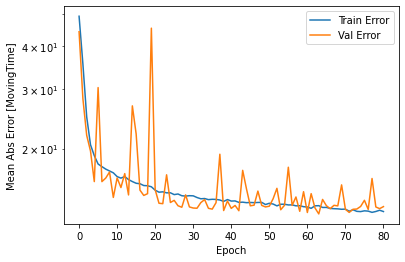

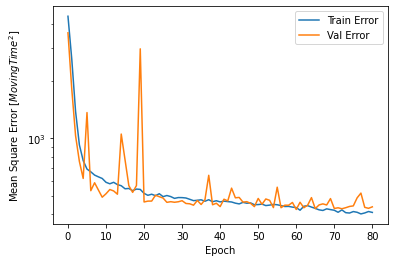

In [11]:
utils.plot_history(history)

As our data set of real GPX tracks is very small, the optimal choice of the epoch for ending training depends on the distribution of tracks between training, validation and testing data. The above choice led to quite stable results.


### Make predictions

Finally, predict walking time values using data in the testing set:

In [12]:
compute_standard_walking_time_vectorized = np.vectorize(utils.compute_standard_walking_time)

standard_estimate_walking_time = compute_standard_walking_time_vectorized(test_dataset['Length2d'].values,
                                                                          test_dataset['TotalUphill'].values,
                                                                          test_dataset['TotalDownhill'].values)

In [13]:
moving_stopped_duration_data_list = []
for index, data in test_labels.iterrows():
    moving_stopped_duration_data_list.append([data['MovingTime'], data['StoppedTime'], data['Duration']])
moving_stopped_duration_data = np.array(moving_stopped_duration_data_list)
moving_stopped_duration_data = np.transpose(moving_stopped_duration_data)


test_predictions = np.transpose(model.predict(test_paths_as_array))

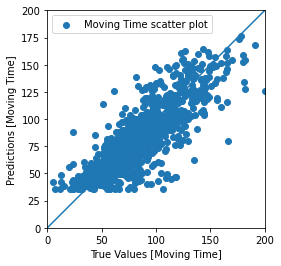

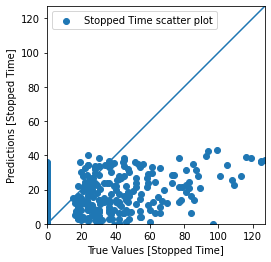

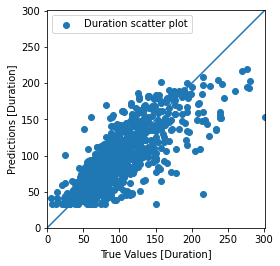

In [14]:
label_texts = ['Moving Time', 'Stopped Time', 'Duration']
    
for i in range(3):
    utils.scatter_plot(moving_stopped_duration_data[i], test_predictions[i], label_texts[i])

It looks like our model predicts reasonably well, as the results should be as close to the diagonal as possible. Let's take a look at the error distribution.

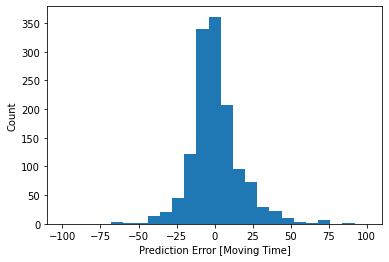

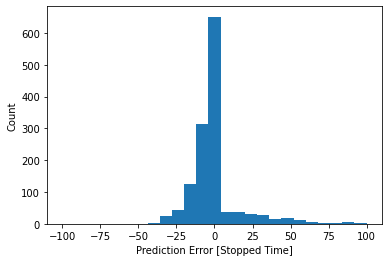

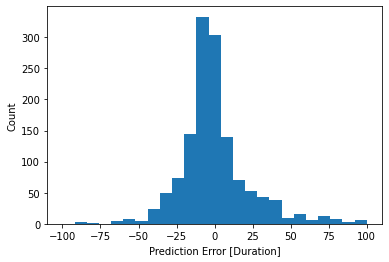

In [15]:
for i in range(3):
    utils.plot_error_hist(moving_stopped_duration_data[i], test_predictions[i], label_texts[i])

It's not quite gaussian, but we might expect that because the number of samples is very small.

Export model for use in inference:

In [16]:
model.save('model_hikingTimePrediction_recurrent.h5')

## Conclusion

This notebook presents the training of an algorithm for predicting moving and stopping times as well as total duration for hiking (but it can also be applied to many other outdoor activities). We accomplished this by treating it as a regression problem.